# Visualize the video

In [148]:
### IMPORT PACKAGES
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import cv2

In [149]:
### DIRECTORY STRUCTURE

# Change this for the video you want
name_of_file = "Two_persons"
directory = "own_videos/outputs/"
file_raw_mp4 = "PHALP_" + name_of_file +".mp4"
file_ffmpg = "PHALP_" + name_of_file + "_ffmpg.mp4"
file_pkl = "results/demo_" + name_of_file + ".pkl"
file_final = name_of_file + "_final.mp4"
file_final_ffmpg = name_of_file + "_final_ffmpg.mp4"

file_mp4_location = directory + file_raw_mp4
file_ffmpg_location = directory + file_ffmpg
file_pkl_location = directory + file_pkl
file_final_location = directory + file_final
file_ffmpg_final_location = directory + file_final_ffmpg

print(file_mp4_location)
print(file_ffmpg_location)
print(file_pkl_location)
print(file_final_location)
print(file_ffmpg_final_location)


own_videos/outputs/PHALP_Two_persons.mp4
own_videos/outputs/PHALP_Two_persons_ffmpg.mp4
own_videos/outputs/results/demo_Two_persons.pkl
own_videos/outputs/Two_persons_final.mp4
own_videos/outputs/Two_persons_final_ffmpg.mp4


In [150]:
### FUNCTIONS

# Display the reconstruction video
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                      <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

def angle_between_vectors(v1, v2):
    # Normalize the input vectors
    v1_normalized = v1 / np.linalg.norm(v1)
    v2_normalized = v2 / np.linalg.norm(v2)

    # Calculate the dot product of the normalized vectors
    dot_product = np.dot(v1_normalized, v2_normalized)

    # Make sure the value is within the valid range for arccos
    # This handles potential floating point errors that might occur
    cos_angle = np.clip(dot_product, -1, 1)

    # Calculate the angle in radians
    angle_radians = np.arccos(cos_angle)

    return angle_radians

def rad2deg(rad):
    deg = rad*180/np.pi
    return deg

def calculateSpeedFromVector(dt, array3D):
    # Calculate differences between consecutive positions
    deltas = np.diff(array3D, axis=0)
    
    # Calculate distances traveled in each step
    distances = np.linalg.norm(deltas, axis=1)
    
    # Calculate speeds by dividing distances by time interval
    speeds = distances / dt

    # Insert a value of 0 for the first element
    speeds = np.insert(speeds, 0, 0.0)
    
    return speeds

In [151]:
!ffmpeg -y -hide_banner -loglevel error -i {file_mp4_location} {file_ffmpg_location}
show_local_mp4_video(file_ffmpg_location, width=960, height=540)

In [152]:
results = joblib.load(file_pkl_location)

In [153]:
# Check for the maximum number of detections!
max_number_detections = 0
current_frame_detections = 0
for frame_number, frame_key in enumerate(sorted(results.keys())):
    frame_data = results[frame_key]
    current_frame_detections = len(frame_data["tid"])
    if(current_frame_detections > max_number_detections):
        max_number_detections = current_frame_detections

print(max_number_detections)

2


In [154]:
# Create list of arrays

number_of_frames = len(results)

l2_distances = [np.zeros(number_of_frames) for _ in range(max_number_detections)]  # Array to hold L2 distance for each frame
left_ankles = [np.zeros((number_of_frames, 2)) for _ in range(max_number_detections)]   # Array to hold left ankle 2D coordinates for each frame
right_ankles = [np.zeros((number_of_frames, 2)) for _ in range(max_number_detections)]  # Array to hold right ankle 2D coordinates for each frame

total_joints = [np.zeros((number_of_frames,90)) for _ in range(max_number_detections)] 
boundary_boxes = [np.zeros((number_of_frames, 4)) for _ in range(max_number_detections)]
center_mass = [np.zeros((number_of_frames, 3)) for _ in range(max_number_detections)]

left_knee_angle = [np.zeros(number_of_frames) for _ in range(max_number_detections)]
right_knee_angle = [np.zeros(number_of_frames) for _ in range(max_number_detections)]

In [155]:
for frame_number, frame_key in enumerate(results.keys()):
    frame_data = results[frame_key]

    for ii in range(max_number_detections):
        # Add boundary box data from each frame
        boundary_boxes[ii][frame_number] = frame_data['tracked_bbox'][ii]

        # Assuming '3d_joints' provides the 3D joint locations
        left_ankle_3d = np.array(frame_data['3d_joints'][ii][7])
        right_ankle_3d = np.array(frame_data['3d_joints'][ii][8])

        # Calculate L2 distance using the 3D coordinates
        l2_distance = np.linalg.norm(right_ankle_3d - left_ankle_3d)
        l2_distances[ii][frame_number] = l2_distance

        # Assuming '2d_joints' provides the 2D projections of the 3D joints
        # Extracting the 2D coordinates for the left and right ankles
        tempx = frame_data['2d_joints'][ii][::2]
        tempy = frame_data['2d_joints'][ii][1::2]

        left_ankle_2d = [tempx[14],tempy[14]]
        right_ankle_2d = [tempx[11],tempy[11]]

        # Add the 2D coordinates to the arrays
        left_ankles[ii][frame_number] = left_ankle_2d
        right_ankles[ii][frame_number] = right_ankle_2d

        total_joints[ii][frame_number] = frame_data['2d_joints'][ii]

        center_mass[ii][frame_number] =  frame_data['3d_joints'][ii][0]

        # Assuming '3d_joints' provides the 3D joint locations
        left_hip_3d = np.array(frame_data['3d_joints'][ii][9])
        left_knee_3d = np.array(frame_data['3d_joints'][ii][10])
        left_ankle_3d = np.array(frame_data['3d_joints'][ii][11])
        # left_toe_3d = np.array(frame_data['3d_joints'][ii][22])

        right_hip_3d = np.array(frame_data['3d_joints'][ii][12])
        right_knee_3d = np.array(frame_data['3d_joints'][ii][13])
        right_ankle_3d = np.array(frame_data['3d_joints'][ii][14])
        # right_toe_3d = np.array(frame_data['3d_joints'][ii][19])

        left_thigh_vector = left_knee_3d - left_hip_3d
        left_calf_vector = left_ankle_3d - left_knee_3d
        # left_foot_vector = left_toe_3d - left_ankle_3d

        right_thigh_vector = right_knee_3d - right_hip_3d
        right_calf_vector = right_ankle_3d - right_knee_3d
        # right_foot_vector = right_toe_3d - right_ankle_3d

        left_knee_angle[ii][frame_number] = rad2deg(np.pi/2.0 - angle_between_vectors(left_thigh_vector,left_calf_vector))
        right_knee_angle[ii][frame_number] = rad2deg(np.pi/2.0 - angle_between_vectors(right_thigh_vector,right_calf_vector))


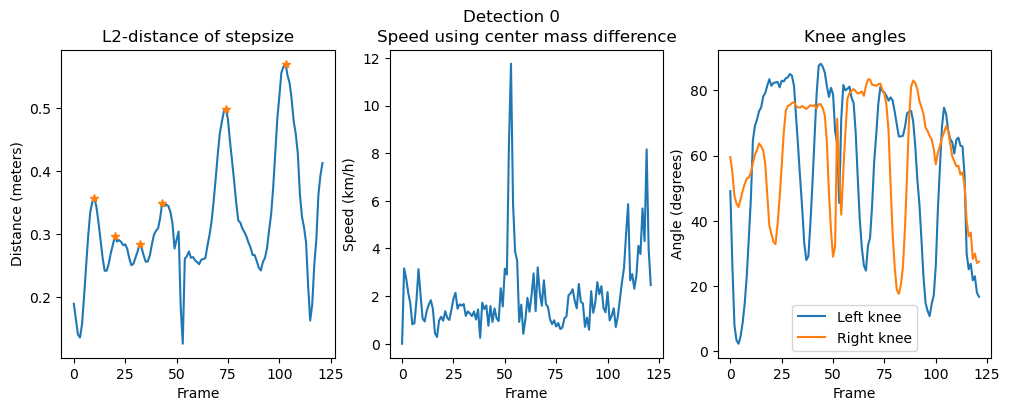

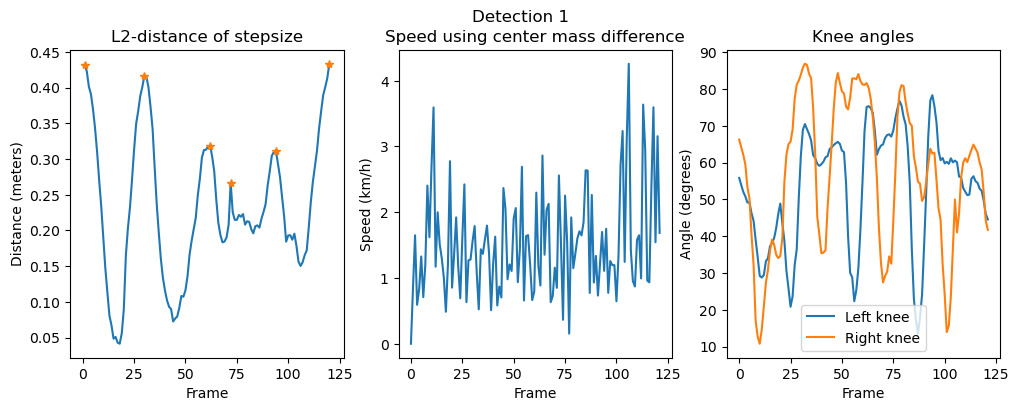

In [156]:
# Open the video
cap = cv2.VideoCapture(file_mp4_location)
fps = cap.get(cv2.CAP_PROP_FPS)
totalNoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
durationInSeconds = totalNoFrames // fps
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

speed = [np.zeros(number_of_frames) for _ in range(max_number_detections)]

local_maxima_indices = [[] for _ in range(max_number_detections)]
local_maxima_values = [[] for _ in range(max_number_detections)]

for ii in range(max_number_detections):
    speed[ii] = calculateSpeedFromVector(1.0/fps,center_mass[ii])
    speed[ii] *= 3.6

    local_maxima_indices[ii] = argrelextrema(l2_distances[ii],np.greater,order=5)[0]
    local_maxima_values[ii] = l2_distances[ii][local_maxima_indices[ii]]

    mean_stride = np.mean(local_maxima_values[ii])

    total_number_of_steps = len(local_maxima_indices[ii])

    average_steps_per_frame = total_number_of_steps / totalNoFrames

    average_steps_per_second = average_steps_per_frame * fps

    distance_per_second = average_steps_per_second * mean_stride
    km_hour = distance_per_second * 3.6
    # print(mean_stride, total_number_of_steps, average_steps_per_frame, average_steps_per_second,distance_per_second, km_hour)
    
    # Subplot definitions 
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Set a common title for the entire subplot
    fig.suptitle("Detection " + str(ii))

    axs[0].set_title("L2-distance of stepsize")
    axs[0].plot(l2_distances[ii])
    axs[0].plot(local_maxima_indices[ii], local_maxima_values[ii], "*")
    axs[0].set_xlabel("Frame")
    axs[0].set_ylabel("Distance (meters)")

    axs[1].set_title("Speed using center mass difference")
    axs[1].plot(speed[ii])
    axs[1].set_xlabel("Frame")
    axs[1].set_ylabel("Speed (km/h)")

    axs[2].set_title("Knee angles")
    axs[2].plot(left_knee_angle[ii])
    axs[2].plot(right_knee_angle[ii])
    axs[2].legend(["Left knee", "Right knee"])
    axs[2].set_xlabel("Frame")
    axs[2].set_ylabel("Angle (degrees)")

    # Display the subplots
    plt.show()    

In [157]:
# If you need to convert an entire list of normalized coordinates:
# left_ankles_pixels = left_ankles * np.array([width, height])
# right_ankles_pixels = right_ankles * np.array([width, height])
#print(right_ankles_pixels)

In [158]:
# Open the video
cap = cv2.VideoCapture(file_mp4_location)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(file_final_location, fourcc, fps, (width, height))

step_count =  [0 for _ in range(max_number_detections)]
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    for ii in range(max_number_detections):

        # Display boundary box
        scale = 1440/1920 # Get scaling factor through dividing new by old dimensions of video
        x,y,w,h = boundary_boxes[ii][frame_number] * scale
        start_point = (int(x),int(y))
        end_point = (int((x+w)) ,int((y+ h)))
        cv2.rectangle(frame, start_point, end_point, (255, 0, 0), 2)

        # Display the L2 distance
        l2_distance = l2_distances[ii][frame_number]
        text = f"L2 distance: {l2_distance:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x =  int(x + w/2 - text_size[0]/2)
        text_y = int(y - 15*1)
        cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display steps taken
        if (frame_number in local_maxima_indices[ii]):
            step_count[ii] += 1
        
        text = f"Steps taken: {int(step_count[ii])}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x =  int(x + w/2 - text_size[0]/2)
        text_y = int(y - 15*2)
        cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Draw a line between the left and right ankles
        # x_coords = total_joints[frame_number][::2] 
        # y_coords = total_joints[frame_number][1::2]
        #print(frame_number)

        # x_min = min(x_coords)
        # x_max = max(x_coords)
        # x_delta = x_max - x_min
        #print(x_delta)

        # y_min = min(y_coords)
        # y_max = max(y_coords)
        # y_delta = y_max - y_min

        # x_scale = w/x_delta
        # y_scale = h/y_delta

        #plt.scatter(x_coords[11] * (x_scale)+(x - x_min*x_scale), y_coords[11] * (y_scale)+(y- y_min*y_scale),s=5, c= "red")
        #print(left_ankles_pixels[frame_number][0]*(x_scale)+(x - x_min*x_scale))

        #left_ankle = tuple(map(int, left_ankles_pixels[frame_number]))
        #right_ankle = tuple(map(int, right_ankles_pixels[frame_number]))
        # left_ankle = (int(left_ankles_pixels[frame_number][0] * (x_scale)+(x - x_min*x_scale)),int( left_ankles_pixels[frame_number][1] * (y_scale)+(y- y_min*y_scale)))
        # right_ankle = (int(right_ankles_pixels[frame_number][0] * (x_scale)+(x - x_min*x_scale)),int( right_ankles_pixels[frame_number][1] * (y_scale)+(y- y_min*y_scale)))
        #print(left_ankle)
        # cv2.line(frame, left_ankle, right_ankle, (255, 0, 0), 2)


        # Display Speed
        speed_per_frame = speed[ii][frame_number]
        text = f" km / h: {speed_per_frame:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x =  int(x + w/2 - text_size[0]/2)
        text_y = int(y - 15*3)
        cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Display knee angles
        left_knee = left_knee_angle[ii][frame_number]
        right_knee = right_knee_angle[ii][frame_number]
        text = f"Left knee: {left_knee:.2f} Right knee: {right_knee:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x =  int(x + w/2 - text_size[0]/2)
        text_y = int(y - 15*4)
        cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        # Display idx of boundary box

    out.write(frame)
    frame_number += 1

# Release everything when job is finished
cap.release()
out.release()


In [159]:
!ffmpeg -y -hide_banner -loglevel error -i {file_final_location} {file_ffmpg_final_location}
show_local_mp4_video(file_ffmpg_final_location, width=960, height=540)